## Replicating Batchkarov et al. (2016) _A critique of word similarity as a method for evaluating distributional semantic models_

This paper argues that the intrinsic evaluation of word embeddings with existing word similarity datasets is problematic. In particular, they argue the following:

- that "word similarity" doesn't make sense outside of the context of a specific task,
- that inter-annotator agreement is low on existing datasets,
- and that the small size of existing datasets leads to too much variation in single number measures. 

I understand their conclusion to be that while word similarity can be used as a coarse evaluation, extrinsic methods should be preferred over intrinsic methods. They also have an interesting proposal for salvaging word similarity as an evaluation method, namely, use word similarity datasets that give increasingly worse evaluations to embeddings as random noise is added.

While Batchkarov et al. do make [their code](https://github.com/mbatchkarov/repeval2016) public, I'd like to do it myself as a learning experience.

They explore five word similarity datasets:

|  Name  	|              Paper             	|
|:------:	|:------------------------------	|
|   RG   	| Rubenstein & Goodenough (1965) 	|
|   MC   	|     Miller & Charles (1995)    	|
|  WS353 	|    Finkelstein et al. (2001)   	|
|   MEN  	|       Bruni et al. (2014)      	|
| SimLex 	|       Hill et al. (2015)       	|

## Definition of word similarity

Their first point is that "word similarity" could mean many different things. They note that many word similarity datasets do not distinguish/are not balanced for lexical semantic relationships (synonymy, antonymy, homonymy, etc.)

In [1]:
## Are the five datasets balanced balanced across lexical relationships?

In [2]:
## Is there a relationship between lexical relationship and empirical similarity?

In [3]:
## Do the five datasets have POS distributions similar to natural text?

In [4]:
## Larger question: Are the five datasets representative of English? Are these words typical English words?

They next note that the similarity judgements assigned to the same pair across datasets differs widely.

In [1]:
import os
import pandas as pd

In [2]:
data_dir = '../evaluate/data'

rg65_path = 'rg-65/rg-65.csv'
mc_path = 'mc/mc.csv'
ws353_path = 'ws-353/ws-353.csv'
men_path = 'men/men.csv'
simlex_path = 'simlex/simlex.csv'

rg65 = pd.read_csv(os.path.join(data_dir, rg65_path))
mc = pd.read_csv(os.path.join(data_dir, mc_path))
ws353 = pd.read_csv(os.path.join(data_dir, ws353_path))
men = pd.read_csv(os.path.join(data_dir, men_path))
simlex = pd.read_csv(os.path.join(data_dir, simlex_path))

In [10]:
ws353.head()

,word1,word2,similarity,which_set?,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,love,sex,6.77,set1,9.0,6.0,8.0,8.0,7.0,8.0,8.0,4.0,7.0,2.0,6.0,7.0,8.0,NaN,NaN,NaN
1,tiger,cat,7.35,set1,9.0,7.0,8.0,7.0,8.0,9.0,8.5,5.0,6.0,9.0,7.0,5.0,7.0,NaN,NaN,NaN
2,tiger,tiger,10.00,set1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,NaN
3,book,paper,7.46,set1,8.0,8.0,7.0,7.0,8.0,9.0,7.0,6.0,7.0,8.0,9.0,4.0,9.0,NaN,NaN,NaN
4,computer,keyboard,7.62,set1,8.0,7.0,9.0,9.0,8.0,8.0,7.0,7.0,6.0,8.0,10.0,3.0,9.0,NaN,NaN,NaN


Concretely, they point out that the pair "chicken-rice" has a normalized score of 0.14 in SimLex but 0.68 in MEN. And that the pair "man-woman" has 0.33 in SimLex but 0.84 in MEN. 

In [14]:
simlex[(simlex['word1']=='chicken') & (simlex['word2']=='rice')]

,word1,word2,POS,similarity,word1_concreteness,word2_concreteness,concreteness_quartile,nelson_norms,top_333_in_nelson,similarity_sd
451,chicken,rice,N,1.43,4.8,4.86,4,0.27,0,1.47


In [17]:
men[(men['word1']=='chicken') & (men['word2']=='rice')]

,word1,word2,similarity_out_of_50,similarity
909,chicken,rice,34.0,6.8


OK, I have two points here:
- Is it OK to normalize similarity scores that weren't originally on a 1-10 scale? (What if the true measurement isn't linear?) I'll put this aside for now.
- What other word pairs do these datasets have in common? Let's take a look.

Merge datasets together on the two word columns.

In [3]:
datasets = ['rg65', 'mc', 'ws353', 'men']
df = simlex[['word1', 'word2', 'similarity']]
df.columns = ['word1', 'word2', 'simlex']

for name in datasets:
    other = eval(name)[['word1', 'word2', 'similarity']]
    other.columns = ['word1', 'word2', name]
    df = pd.merge(df, other, how='outer', on=['word1', 'word2'])

Word pairs present in more than one dataset will less than four NaN in a row

In [8]:
duplicates = df[['rg65', 'mc', 'ws353', 'men', 'simlex']].isnull().sum(axis=1) < 4

In [13]:
duplicates.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [35]:
tmp = df[duplicates][['simlex', 'rg65', 'mc', 'ws353', 'men']].values

In [50]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.spatial.distance import pdist

In [51]:
# this is hacky, I'd like to have a better solution than this.
values = df[duplicates][['simlex', 'rg65', 'mc', 'ws353', 'men']].values
distances = []
for row in values:
    row = row.reshape(-1,1)
    d = pdist(row)
    distances.extend([i for i in d if not np.isnan(i)])

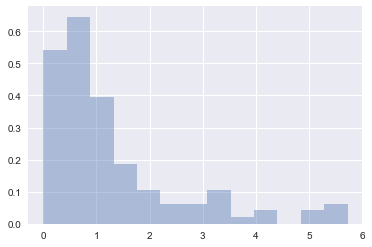

In [53]:
sns.distplot(distances, kde=False, norm_hist=True);